<a href="https://colab.research.google.com/github/Gsha36/resnet-transformer-eye-disease-detection/blob/main/resnet%2Bvts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/eye-diseases-classification


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import OneCycleLR

# Constants
BATCH_SIZE = 32
MAX_EPOCHS = 60
BASE_LR = 1e-4  # Increased from 3e-5
CNN_LR = 5e-5   # Increased from 1e-6
IMAGE_SIZE = 224
NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# Custom Dataset
class RetinalDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []

        # Load images with balanced class sampling
        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)
                      if img.lower().endswith(('.jpg', '.jpeg'))]
            self.images.extend(images)
            self.labels.extend([self.class_to_idx[class_name]] * len(images))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

# Enhanced Data Transformations
def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1))
    ])

    val_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

# Stratified Data Split (70% train, 15% val, 15% test)
def prepare_data(data_dir):
    train_transform, val_transform = get_transforms()

    full_dataset = RetinalDataset(data_dir)

    # First split: 70% train, 30% temp
    train_idx, temp_idx = train_test_split(
        range(len(full_dataset)),
        test_size=0.3,
        stratify=full_dataset.labels,
        random_state=42
    )

    # Split temp into val and test (1:1)
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=0.5,
        stratify=[full_dataset.labels[i] for i in temp_idx],
        random_state=42
    )

    # Create datasets
    train_dataset = RetinalDataset(data_dir, transform=train_transform)
    val_dataset = RetinalDataset(data_dir, transform=val_transform)
    test_dataset = RetinalDataset(data_dir, transform=val_transform)

    # Assign splits
    train_dataset.images = [full_dataset.images[i] for i in train_idx]
    train_dataset.labels = [full_dataset.labels[i] for i in train_idx]

    val_dataset.images = [full_dataset.images[i] for i in val_idx]
    val_dataset.labels = [full_dataset.labels[i] for i in val_idx]

    test_dataset.images = [full_dataset.images[i] for i in test_idx]
    test_dataset.labels = [full_dataset.labels[i] for i in test_idx]

    # Data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        persistent_workers=True,
        pin_memory=True,
        prefetch_factor=2
    )
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=2, pin_memory=True)

    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    return train_loader, val_loader, test_loader, full_dataset.classes

# Hybrid ResNet-Transformer Model
class RetinalHybrid(nn.Module):
    def __init__(self):
        super().__init__()
        # ResNet50 backbone
        self.cnn = models.resnet50(weights='IMAGENET1K_V2')
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-2])

        # Transformer Encoder
        self.transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=2048, nhead=8, dim_feedforward=4096, dropout=0.2, # Increased dropout
                batch_first=True, norm_first=False),
            num_layers=4,
            enable_nested_tensor=True
        )

        # Adaptive Fusion Gate
        self.fusion_gate = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),  # Increased dropout from 0.3
            nn.Linear(2048, NUM_CLASSES)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.transformer.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        for m in self.fusion_gate.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        # CNN Features
        cnn_features = self.cnn(x)  # [B, 2048, 7, 7]
        b, c, h, w = cnn_features.shape
        cnn_flat = cnn_features.view(b, c, -1).permute(0, 2, 1)  # [B, 49, 2048]

        # Transformer Features
        transformer_features = self.transformer(cnn_flat)  # [B, 49, 2048]

        # Adaptive Fusion
        combined = torch.cat([cnn_flat, transformer_features], dim=-1)
        gate = self.fusion_gate(combined)
        fused = gate * cnn_flat + (1 - gate) * transformer_features

        # Classification
        pooled = fused.mean(dim=1)  # [B, 2048]
        return self.classifier(pooled)

# Boundary-Aware Focal Loss with Label Smoothing
class BAFocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=3.5, smoothing=0.1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing
        self.num_classes = NUM_CLASSES

    def forward(self, inputs, targets):
        # Apply label smoothing
        targets_one_hot = torch.zeros_like(inputs).scatter_(1, targets.unsqueeze(1), 1)
        targets_smoothed = targets_one_hot * (1 - self.smoothing) + self.smoothing / self.num_classes

        log_probs = nn.functional.log_softmax(inputs, dim=1)
        # Basic cross entropy with smoothing
        loss = -(targets_smoothed * log_probs).sum(dim=1)

        # Apply focal weighting
        pt = torch.exp(-loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * loss
        return focal_loss.mean()

# Improved Training Configuration with Layer-wise Learning Rates
def configure_optimizer(model):
    # More granular parameter groups with decreasing learning rates for CNN layers
    param_groups = [
        {'params': [p for n, p in model.cnn.named_parameters() if 'layer1' in n or 'layer2' in n],
         'lr': CNN_LR * 0.5, 'weight_decay': 0.01},  # Early layers - lower LR, lower decay
        {'params': [p for n, p in model.cnn.named_parameters() if 'layer3' in n],
         'lr': CNN_LR * 0.75, 'weight_decay': 0.03},  # Middle layers
        {'params': [p for n, p in model.cnn.named_parameters() if 'layer4' in n or not any(l in n for l in ['layer1', 'layer2', 'layer3', 'layer4'])],
         'lr': CNN_LR, 'weight_decay': 0.05},  # Later CNN layers
        {'params': model.transformer.parameters(), 'lr': BASE_LR, 'weight_decay': 0.05},
        {'params': model.fusion_gate.parameters(), 'lr': BASE_LR * 1.5, 'weight_decay': 0.05},
        {'params': model.classifier.parameters(), 'lr': BASE_LR * 2, 'weight_decay': 0.1}  # Higher for classifier
    ]

    optimizer = optim.AdamW(param_groups)

    return optimizer

# Training Loop with Early Stopping and OneCycleLR
def train_model(model, train_loader, val_loader, test_loader, classes):
    criterion = BAFocalLoss(smoothing=0.1)
    optimizer = configure_optimizer(model)

    # OneCycleLR scheduler
    scheduler = OneCycleLR(
        optimizer,
        max_lr=[CNN_LR * 0.5 * 10, CNN_LR * 0.75 * 10, CNN_LR * 10,
                BASE_LR * 10, BASE_LR * 1.5 * 10, BASE_LR * 2 * 10],
        steps_per_epoch=len(train_loader),
        epochs=MAX_EPOCHS,
        pct_start=0.3,  # Spend 30% of training ramping up LR
        div_factor=25,  # Initial LR = max_lr/div_factor
        final_div_factor=1000  # Final LR = max_lr/final_div_factor
    )

    # Early stopping setup
    early_stopping_patience = 15
    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0

    # Checkpoint tracking
    checkpoints = [0.75, 0.80, 0.85, 0.90, 0.95]
    checkpoint_saved = {threshold: False for threshold in checkpoints}

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(MAX_EPOCHS):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        print(f'Epoch {epoch+1}/{MAX_EPOCHS}')

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Reduced from 5.0 for better stability

            optimizer.step()
            scheduler.step()  # Update LR after each batch

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            # Print progress
            if (batch_idx + 1) % 20 == 0 or batch_idx + 1 == len(train_loader):
                print(f'Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f} | '
                      f'Acc: {100.*correct/total:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f}')

        train_loss = train_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        class_correct = [0] * NUM_CLASSES
        class_total = [0] * NUM_CLASSES

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

                # Per-class accuracy
                for i in range(labels.size(0)):
                    label = labels[i].item()
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

        val_loss = val_loss / total
        val_acc = correct / total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print validation results
        print(f'Validation Loss: {val_loss:.4f} | Acc: {val_acc:.4f}')

        # Print per-class accuracy
        for i in range(NUM_CLASSES):
            class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
            print(f'Accuracy of {classes[i]}: {100 * class_acc:.2f}%')

        # Save checkpoints at specific validation accuracy thresholds
        for threshold in checkpoints:
            if val_acc > threshold and not checkpoint_saved[threshold]:
                torch.save(model.state_dict(), f'model_acc_{threshold:.2f}.pth')
                checkpoint_saved[threshold] = True
                print(f'Saved checkpoint at accuracy {threshold:.2f}')

        # Early stopping check
        if val_acc > best_val_acc:
            print(f"Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}")
            best_val_acc = val_acc
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_hybrid_model.pth')
            print("Saved best model")
        else:
            patience_counter += 1
            print(f"Validation accuracy did not improve. Patience: {patience_counter}/{early_stopping_patience}")

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Final test evaluation
    print("\nLoading best model for testing...")
    model.load_state_dict(torch.load('best_hybrid_model.pth'))
    model.eval()
    test_correct = 0
    test_total = 0

    # Initialize confusion matrix
    confusion_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            # Update confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

            test_correct += predicted.eq(labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct/test_total
    print(f'\nFinal Test Accuracy: {test_acc:.4f}')

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix)
    print("\nPer-class Test Accuracy:")
    for i in range(NUM_CLASSES):
        class_acc = confusion_matrix[i, i].item() / confusion_matrix[i, :].sum().item()
        print(f'{classes[i]}: {class_acc:.4f}')

    return model, history

Using device: cuda


In [ ]:
# Main Execution
if __name__ == "__main__":
    data_dir = "/kaggle/input/eye-diseases-classification/dataset"
    train_loader, val_loader, test_loader, classes = prepare_data(data_dir)

    model = RetinalHybrid().to(DEVICE)
    trained_model, history = train_model(model, train_loader, val_loader, test_loader, classes)

Train: 2811, Val: 602, Test: 603


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


Epoch 1/60
Batch 20/88 | Loss: 0.2884 | Acc: 45.62% | LR: 0.000010
Batch 40/88 | Loss: 0.5795 | Acc: 49.61% | LR: 0.000010
Batch 60/88 | Loss: 0.2377 | Acc: 52.03% | LR: 0.000011
Batch 80/88 | Loss: 0.2230 | Acc: 54.38% | LR: 0.000012
Batch 88/88 | Loss: 0.1960 | Acc: 55.82% | LR: 0.000012
Validation Loss: 0.1517 | Acc: 0.7475
Accuracy of cataract: 92.86%
Accuracy of diabetic_retinopathy: 71.52%
Accuracy of glaucoma: 54.41%
Accuracy of normal: 79.50%
Validation accuracy improved from 0.0000 to 0.7475
Saved best model
Epoch 2/60
Batch 20/88 | Loss: 0.2079 | Acc: 70.47% | LR: 0.000013
Batch 40/88 | Loss: 0.1180 | Acc: 73.98% | LR: 0.000014
Batch 60/88 | Loss: 0.1537 | Acc: 74.01% | LR: 0.000015
Batch 80/88 | Loss: 0.2131 | Acc: 74.14% | LR: 0.000017
Batch 88/88 | Loss: 0.3081 | Acc: 73.78% | LR: 0.000017
Validation Loss: 0.1505 | Acc: 0.7791
Accuracy of cataract: 93.57%
Accuracy of diabetic_retinopathy: 73.33%
Accuracy of glaucoma: 50.74%
Accuracy of normal: 91.93%
Saved checkpoint at ac

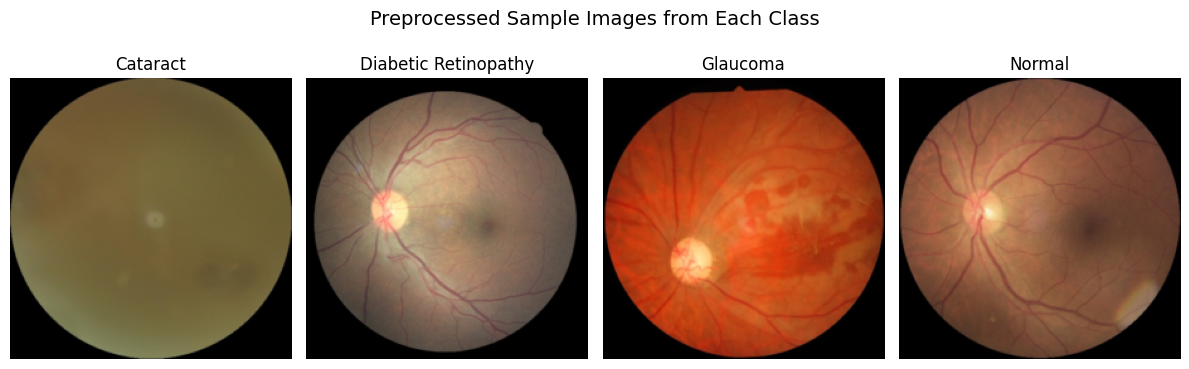

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os

# Re-use your validation preprocessing (from get_transforms)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset and class info
data_dir = "/kaggle/input/eye-diseases-classification/dataset"
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# Visualization
plt.figure(figsize=(12, 4))
for idx, cls in enumerate(classes):
    class_path = os.path.join(data_dir, cls)
    img_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg'))])

    if not img_files:
        continue  # Skip if no images found

    # Load and preprocess image
    img_path = os.path.join(class_path, img_files[0])
    img = Image.open(img_path).convert("RGB")
    img_tensor = val_transform(img)

    # Convert tensor to displayable image (unnormalize)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    img_np = img_np.clip(0, 1)

    # Plot
    plt.subplot(1, 4, idx + 1)
    plt.imshow(img_np)
    plt.title(cls.replace('_', ' ').title())
    plt.axis('off')

plt.suptitle("Preprocessed Sample Images from Each Class", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Example variables from your final output
y_true = [0]*141 + [1]*165 + [2]*136 + [3]*159  # actual labels by class
y_pred = (
    [0]*137 + [2]*1 + [3]*3 +                      # cataract
    [1]*163 + [2]*1 + [3]*1 +                      # diabetic_retinopathy
    [0]*3 + [2]*125 + [3]*8 +                      # glaucoma
    [0]*5 + [2]*13 + [3]*143                       # normal
)
class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [ ]:
from google.colab import files
files.download("best_hybrid_model.pth") # Changed filename to 'best_hybrid_model.pth'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os

# Constants from the original code
IMAGE_SIZE = 224
NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASSES = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# Define the model architecture (same as RetinalHybrid)
class RetinalHybrid(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = torch.nn.Sequential(*list(torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).children())[:-2])
        self.transformer = torch.nn.TransformerEncoder(
            encoder_layer=torch.nn.TransformerEncoderLayer(
                d_model=2048, nhead=8, dim_feedforward=4096, dropout=0.2, batch_first=True),
            num_layers=4
        )
        self.fusion_gate = torch.nn.Sequential(
            torch.nn.Linear(4096, 1),
            torch.nn.Sigmoid()
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.4),
            torch.nn.Linear(2048, NUM_CLASSES)
        )

    def forward(self, x):
        cnn_features = self.cnn(x)
        b, c, h, w = cnn_features.shape
        cnn_flat = cnn_features.view(b, c, -1).permute(0, 2, 1)
        transformer_features = self.transformer(cnn_flat)
        combined = torch.cat([cnn_flat, transformer_features], dim=-1)
        gate = self.fusion_gate(combined)
        fused = gate * cnn_flat + (1 - gate) * transformer_features
        pooled = fused.mean(dim=1)
        return self.classifier(pooled)

# Image transformation (same as validation transform)
def get_test_transform():
    return transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Function to predict disease for a single image
def predict_image(image_path, model_path='best_hybrid_model.pth'):
    # Validate image path
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at {image_path}")

    # Load model
    model = RetinalHybrid().to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    # Load and preprocess image
    transform = get_test_transform()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

    # Predict
    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        predicted_idx = torch.argmax(probabilities).item()
        predicted_class = CLASSES[predicted_idx]

    # Return results
    return {
        'predicted_disease': predicted_class,
        'probabilities': {CLASSES[i]: prob.item() for i, prob in enumerate(probabilities)}
    }

# Example usage
if __name__ == "__main__":
    image_path = "/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy/10003_left.jpeg"
    try:
        result = predict_image(image_path)
        print(f"Predicted Disease: {result['predicted_disease']}")
        print("Probabilities:")
        for cls, prob in result['probabilities'].items():
            print(f"{cls}: {prob:.4f}")
    except Exception as e:
        print(f"Error: {e}")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Predicted Disease: diabetic_retinopathy
Probabilities:
cataract: 0.0285
diabetic_retinopathy: 0.9409
glaucoma: 0.0202
normal: 0.0104
